# Federal Contracts FY2016

#### Team Members:
* Kelly Berdelle
* Daniel Chen
* Kevin Fitzgerald
* Naveen Ithikkat

Attestation: All team members contributed substantially to this final product. At every stage -- from selecting a dataset to reporting results -- one of us took the lead and the others consulted.


## Executive Summary
### Selection
We wanted to work with a large data set. We spent nearly a week considering scores of datasets ranging from climate data through Kaggle competitions. We settled on federal contracts from usaspending.gov (see Introduction - data selection). It is the first dataset of transactional grain that we all liked. If we looked at a full fiscal year we could avoid seasonality and have a plenty large dataset. Initial exploration clarified our key questions. We wanted to follow the money. We wanted to determine which agencies were letting the most contracts and for the largest total amounts (and which vendors were getting them). While the data did exhibit some small imperfections, it generally appeared very clean. So we did not need to clean the data as these small imperfections would not alter any of the high level results we were after. The only real challenge would be to reliably process such a large dataset in a replicable notebook.
### Wrangling
Our inital dataset (4.2M records with 225 variables) immediately hit storage and processing limits on datanotebook.org. So we dropped all but 28 variables. But the data was still too large to handle. So we took a 1/16 sample. These two steps (taking a subset and taking a sample) take 8-10 minutes total to complete (the longest steps in this notebook). But they yield a dataset that can be loaded into a database. All steps are documented in 'Data acquisition and exploration'.

The data is then loaded into a database in a star schema with 3 dimension tables. At every stage in its design we take care to ensure all data is loaded and there are no orphaned records. All steps are documented in 'Load data into database'.
### Analysis
Here we follow the money. We see that most of the top ten agencies and all of the top ten contracts are in the defense industry. More specifically, the highest value contracts procure aircraft. We were surpised to see that the signing of federal contracts is generally evenly distributed throughout the fiscal year (initial exploration indicated that as any as half of all contracts were signed in the first two months of the fiscal year). Our summary analysis indicates that the federal government is spending a great deal of contract money on equipment to be used by the Department of Defense.


## Outline
* Introduction - data selection
* Loading the Data
    Data acquisition and exploration
    Load data into database
* Analyzing the Data
* Conclusion


## Introduction - data selection

We took a look at dozens of data sets for this project. We wanted to work with a large data set with a transactional grain. There is no shortage of data to examine. We briefly considered genomic data, web-scraped click-through data, meteorological and climate change data, data from Kaggle competitions, etc. Daniel suggested we look at federal contracts data. We all liked the idea. We shared the objective of simply summarizing the data to determine where the federal contracting dollars were going and what they were buying. It met all our requirements. It has a transactional grain, we could avoid seasonality (if any) by looking at an entire fiscal year and the dataset was large.

For this project, we studied US federal contracts from fiscal year 2016, beginning October 1, 2015. Our data is from usaspending.gov, a public website that displays data "to give the American public access to information on how their tax dollars are being spent." While federal spending includes grants, loans, and other financial assistance, we focus on federal contracts, since federal contracting is a field we may enter upon graduation from GWSB. 

The overview chart below shows that contracts are a relatively small part of overall federal payments. More than USD 425b in contract payments were made in FY2016. This sounds like a lot of money. And it is. But it's quite small compared to grants (USD 654b) and other (USD 1.7t includes: social security, medicare, medicaid, etc.).

![](https://docs.google.com/drawings/d/1tucW-QQ8VDZU3BTlR9ic1WeyciMzqOd9oWzi0d_Q_yo/pub?w=957&h=593)

## Loading the Data
We examine data on federal contracts during Fiscal Year 2016 (November 2015 through October 2016). This dataset has approximately 4.2 million records, so we will need to use special techniques to process this data on datanotebook.org.

### Data acquisition and exploration

In [1]:
!wget "http://download.usaspending.gov/data_archives/201611/csv/2016_All_Contracts_Full_20161115.csv.zip"

Our initial data file contains 4.2 million transactions and 225 variables. It is 969MB zipped and nearly 9GB expanded. Datanotebook.org allocates ~4GB of working storage. As such, a full fiscal year of federal contracts is simply too large for our workspace. So we begin by extracting 28 variables of interest. Expect this extraction cell to take 6-8 minutes to complete on datanotebook.org. 

In [2]:
!zcat '2016_All_Contracts_Full_20161115.csv.zip' | csvcut -c 1,3,4,5,6,9,10,14,15,16,17,44,56,57,58,59,65,66,71,81,84,120,121,129,130,137,143,145 > first_cut.csv

Because we're concerned about space, we compress our data at all times.

In [3]:
!gzip first_cut.csv

This 'first_cut' subset of 28 variables is 1.8GB but compresses to 328MB when zipped.

In [4]:
!ls -lah

total 1.3G
drwxr-xr-x  3 jovyan users  151 Dec  6 22:29 .
drwxr-xr-x 11 jovyan users 4.0K Sep 28 20:02 ..
-rw-r--r--  1 jovyan users 969M Nov 21 04:55 2016_All_Contracts_Full_20161115.csv.zip
-rw-r--r--  1 jovyan users  46K Dec  6 22:28 FederalContracts9.ipynb
-rw-r--r--  1 jovyan users 328M Dec  6 22:28 first_cut.csv.gz
drwxr-xr-x  2 jovyan users   47 Dec  6 22:21 .ipynb_checkpoints
-rw-r--r--  1 root   root  1.4K Oct  7 00:17 .nbgrader.log


In [5]:
!zcat 'first_cut.csv' | wc -l

4202303


Even so the 28 variable subset is still unwieldy. With 4.2 million records all attempts to report descriptive statistics (csvstat) on even one variable are immediately killed. 

In [6]:
!zcat 'first_cut.csv' | csvstat -c 2

Killed

gzip: stdout: Broken pipe


So we must work with a sample. We could use !shuf to draw a sample, but it may not complete and will not be replicable unless a seed is specified. We were unable to make it work here. Instead, we use csvgrep on unique_transaction_ID (a unique 32 character hexadecimal (0-f) string) to draw a 1/16 sample. We select every observation with a specified first character (in this case '0').

In [7]:
!zcat 'first_cut.csv' | csvgrep -c 1 -r "^0" > Sample.csv

In [8]:
!wc -l Sample.csv

263230 Sample.csv


In [9]:
!gzip Sample.csv

In [10]:
!zcat 'Sample.csv' | csvclean

No errors.


In [11]:
!ls -lah

total 1.4G
drwxr-xr-x  3 jovyan users 4.0K Dec  6 22:30 .
drwxr-xr-x 11 jovyan users 4.0K Sep 28 20:02 ..
-rw-r--r--  1 jovyan users 969M Nov 21 04:55 2016_All_Contracts_Full_20161115.csv.zip
-rw-r--r--  1 jovyan users  47K Dec  6 22:30 FederalContracts9.ipynb
-rw-r--r--  1 jovyan users 328M Dec  6 22:28 first_cut.csv.gz
drwxr-xr-x  2 jovyan users   47 Dec  6 22:21 .ipynb_checkpoints
-rw-r--r--  1 root   root  1.4K Oct  7 00:17 .nbgrader.log
-rw-r--r--  1 jovyan users  23M Dec  6 22:30 Sample.csv.gz
-rw-r--r--  1 jovyan users 110M Dec  6 22:31 <stdin>_out.csv


The resulting 'Sample' dataset has ~263,000 observations and requires only 23MB of storage space. So now we have a dataset that can be handled within the working storage on datanotebook.org. The extracted variables and brief descriptions of each (from the data dictionary) are provided below. (The data dictionary for the original dataset is also included in the submitted zip file.)

In [12]:
!zcat 'Sample.csv' | csvcut -n

  1: unique_transaction_id
  2: dollarsobligated
  3: baseandexercisedoptionsvalue
  4: baseandalloptionsvalue
  5: maj_agency_cat
  6: contractingofficeagencyid
  7: contractingofficeid
  8: signeddate
  9: effectivedate
 10: currentcompletiondate
 11: ultimatecompletiondate
 12: vendorname
 13: city
 14: state
 15: zipcode
 16: vendorcountrycode
 17: dunsnumber
 18: parentdunsnumber
 19: mod_parent
 20: productorservicecode
 21: principalnaicscode
 22: numberofemployees
 23: annualrevenue
 24: womenownedflag
 25: veteranownedflag
 26: minorityownedbusinessflag
 27: nonprofitorganizationflag
 28: isforprofitorganization

gzip: stdout: Broken pipe


### Brief description of each variable

1: unique_transaction_id -- The unique identifying record id.

2: dollarsobligated -- The net dollar amount that is obligated or deobligated by this transaction.

3: baseandalloptionsvalue -- Mutually agreed total contract or order value including all options (if any).

4: baseandexercisedoptionsvalue -- The contract value for the base contract and any options that have been exercised.

5: maj_agency_cat -- Major federal organization, department and its description.

6: contractingofficeagencyid -- Code for agency or bureau that is responsible for the transaction. 

7: contractingofficeid -- Code for the contracting office that executes the transaction. 

8: signeddate -- The date signed by the Contracting Officer or the Contractor, whichever is later. 

9: effectivedate -- The date that the parties agree will be the starting date for the contract's requirements. 

10: currentcompletiondate -- The current expected or scheduled contract completion date. 

11: ultimatecompletiondate -- The estimated or scheduled completion date including all options (if any). 

12: vendorname -- The name of the vendor awarded the contract as it appears in Central Contractor Registry (CCR). 

13: city -- The city of the contractor address. 

14: state -- The state in the contractor address. 

15: zipcode -- The zip code in the contractor address. 

16: vendorcountrycode -- The country code in the contractor address. 

17: dunsnumber -- The Dun & Bradstreet number of the vendor - used to link to the CCR. 

18: parentdunsnumber -- The Dun & Bradstreet number of the vendor's parent company. 

19: mod_parent -- The parent company for the vendor, as provided by D&B. 

20: productorservicecode -- The code that best identifies the product or service procured. 

21: principalnaicscode -- The principal North American Industry Classification System (NAICS) code. 

22: numberofemployees -- The contractor's business size in terms of number of employees. 

23: annualrevenue -- The contractor's annual gross revenue, taken from an average of the last three years.  

24: womenownedflag -- Indicates whether the vendor is a Woman Owned Business. 

25: veteranownedflag -- Indicates whether the vendor is a Veteran Owned Business. 

26: minorityownedbusinessflag -- Indicates whether the vendor is a Minority Owned Business. 

27: nonprofitorganizationflag -- Indicates whether the vendor is a Nonprofit Organization. 

28: isforprofitorganization -- Indicates whether the vendor is a Profit Organization or not. 


.

Next we generate descriptive statistics. To save time we limit csvstat to the first 50,000 records.

In [13]:
!zcat 'Sample.csv' | head -n 50000 | csvstat


gzip: stdout: Broken pipe
  1. unique_transaction_id
	<class 'str'>
	Nulls: False
	Unique values: 49997
	Max length: 32
  2. dollarsobligated
	<class 'float'>
	Nulls: False
	Min: -24000000.0
	Max: 252000000.0
	Sum: 5180707430.349998
	Mean: 103620.36582894971
	Median: 768.87
	Standard Deviation: 2271200.586516295
	Unique values: 33118
	5 most frequent values:
		0.0:	8687
		5000.0:	79
		10000.0:	66
		25000.0:	51
		100000.0:	49
  3. baseandexercisedoptionsvalue
	<class 'float'>
	Nulls: False
	Min: -77842422.0
	Max: 700000000.0
	Sum: 5106615969.099995
	Mean: 102138.44768886123
	Median: 600.51
	Standard Deviation: 3838225.2046538806
	Unique values: 32242
	5 most frequent values:
		0.0:	9940
		5000.0:	76
		10000.0:	59
		400.28:	47
		6.23:	47
  4. baseandalloptionsvalue
	<class 'float'>
	Nulls: False
	Min: -98909671.03
	Max: 22300000000.0
	Sum: 45049208919.46999
	Mean: 901038.2406838409
	Median: 567.0
	Standard Deviation: 117877206.05804636
	Unique values: 32022
	5 most frequent values:
		0.

.

There is clearly some noise in the data. See values for 'womenownedbusiness' and only 49,997 cases are reported where 50,000 were specified. However, we expect these imperfections in a few cases will not alter the high-level results we seek to report. As such they are not worth cleaning. So after an initial look at the some actual transaction data below, we will proceed to load the data into a database.

Here is a look at some of the values in the first ten records.

In [14]:
!zcat 'Sample.csv' | csvcut -c 1:4 | head -n 10 | csvlook


gzip: stdout: Broken pipe
|-----------------------------------+------------------+------------------------------+-------------------------|
|  unique_transaction_id            | dollarsobligated | baseandexercisedoptionsvalue | baseandalloptionsvalue  |
|-----------------------------------+------------------+------------------------------+-------------------------|
|  0203984a0b5149ebad327fae72a8debc | 3958.00          | 3958.00                      | 3958.00                 |
|  0d6caed974b14c87a146f9cb8c22130b | 4484.00          | 4484.00                      | 4484.00                 |
|  0b952febb54d4d4cb974a21c133dbab3 | 31079.84         | 31079.84                     | 31079.84                |
|  0c0c27904bbd467aa90b1a8cf76fdfa3 | 0.00             | 0.00                         | 0.00                    |
|  0e94dae69f4a4193934876819e316aff | 15000.00         | 15000.00                     | 15000.00                |
|  0731e224233444ca9aaa3ce492b1cc3d | 3443.30          | 3443

Note: Our examination of these three contract amount variables show that 'dollarsobligated' is the most consistent of the three. As such, we interpret 'dollarsobligated' as representing the dollar amount of each unique contract in the dataset. According to the definition 'baseandexercisedoptionsvalue' might be more accurate. But in this dataset it is not as consistently reported as is 'dollarsobligated'.

In [15]:
!zcat 'Sample.csv' | csvcut -c 6:8 | head -n 10 | csvlook


gzip: stdout: Broken pipe
|---------------------------------------+---------------------------------------------+-------------|
|  contractingofficeagencyid            | contractingofficeid                         | signeddate  |
|---------------------------------------+---------------------------------------------+-------------|
|  1540: FEDERAL PRISON SYSTEM          | 30303: EDGEFIELD, FCI                       | 10/01/2015  |
|  1540: FEDERAL PRISON SYSTEM          | 50302: BIG SPRING, FCI                      | 10/01/2015  |
|  1540: FEDERAL PRISON SYSTEM          | 30902: MIAMI, FCI                           | 10/01/2015  |
|  1448: U.S. FISH AND WILDLIFE SERVICE | 00001: CONTRACTING AND GENERAL SERVICES DIV | 10/01/2015  |
|  1501: OFFICES, BOARDS AND DIVISIONS  | CIV01: CIVIL DIVISION                       | 10/01/2015  |
|  1540: FEDERAL PRISON SYSTEM          | 41407: SPRINGFIELD, USMCFP                  | 10/01/2015  |
|  1540: FEDERAL PRISON SYSTEM          | 30902: MIAMI,

In [16]:
!zcat 'Sample.csv' | csvcut -c 12:16 | head -n 10 | csvlook

|---------------------------------------+--------------+-------+---------+--------------------------------|
|  vendorname                           | city         | state | zipcode | vendorcountrycode              |
|---------------------------------------+--------------+-------+---------+--------------------------------|
|  CLARK'S TRADING CO.                  | MUKWONAGO    | WI    | 53149   | USA: UNITED STATES OF AMERICA  |
|  FLAVORPROS, LLC                      | ALLENTOWN    | PA    | 18102   | USA: UNITED STATES OF AMERICA  |
|  BORDEN DAIRY COMPANY OF FLORIDA, LLC | WINTER HAVEN | FL    | 33880   | USA: UNITED STATES OF AMERICA  |
|  UNITED STATES POSTAL SERVICE         | SAINT PAUL   | MN    | 55121   | USA: UNITED STATES OF AMERICA  |
|  R & R CONSULTING                     | NEW YORK     | NY    | 10017   | USA: UNITED STATES OF AMERICA  |
|  BENJAMIN FOODS L.L.C.                | HATBORO      | PA    | 19040   | USA: UNITED STATES OF AMERICA  |
|  EPTA SOLUTIONS, LLC      

We're using 1.4GB of storage space (out of roughly ~ 4GB available) to store our original data (969MB), a first_cut (328MB) and this Sample (23MB) all in compressed format. We may delete the raw data and the first_cut if space is needed to load the data into a SQL database. 

In [17]:
!ls -lah

total 1.4G
drwxr-xr-x  3 jovyan users 4.0K Dec  6 22:30 .
drwxr-xr-x 11 jovyan users 4.0K Sep 28 20:02 ..
-rw-r--r--  1 jovyan users 969M Nov 21 04:55 2016_All_Contracts_Full_20161115.csv.zip
-rw-r--r--  1 jovyan users  47K Dec  6 22:30 FederalContracts9.ipynb
-rw-r--r--  1 jovyan users 328M Dec  6 22:28 first_cut.csv.gz
drwxr-xr-x  2 jovyan users   47 Dec  6 22:21 .ipynb_checkpoints
-rw-r--r--  1 root   root  1.4K Oct  7 00:17 .nbgrader.log
-rw-r--r--  1 jovyan users  23M Dec  6 22:30 Sample.csv.gz
-rw-r--r--  1 jovyan users 110M Dec  6 22:31 <stdin>_out.csv


### Load Data into Database

We will first connect to postgreSQL database USGovContracts in order to create a master table to contain our data.

In [18]:
%load_ext sql
!echo 'redspot' | sudo -S service postgresql restart
!createdb -U dbuser USGovContracts
%sql postgresql://dbuser@localhost:5432/USGovContracts

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


'Connected: dbuser@USGovContracts'

Next, we create our master table and load the data.

In [19]:
%%sql
DROP TABLE IF EXISTS Master;
CREATE TABLE Master (
    unique_transaction_id CHAR(32),
    dollarsobligated REAL,
    baseandexercisedoptionsvalue REAL,
    baseandalloptionsvalue REAL,
    maj_agency_cat CHAR (165),
    contractingofficeagencyid CHAR (75),
    contractingofficeid CHAR (75),
    signeddate TIMESTAMP,
    effectivedate TIMESTAMP,
    currentcompletiondate TIMESTAMP,
    ultimatecompletiondate TIMESTAMP,
    vendorname CHAR (255),
    city CHAR (80),
    state CHAR (40),
    zipcode CHAR(5),
    vendorcountrycode VARCHAR (50),
    dunsnumber INTEGER,
    parentdunsnumber INTEGER,
    mod_parent CHAR (120),
    productorservicecode CHAR (255),
    principalnaicscode CHAR (255),
    numberofemployees REAL,
    annualrevenue REAL,
    womenownedflag BOOLEAN,
    veteranownedflag BOOLEAN,
    minorityownedbusinessflag BOOLEAN,
    nonprofitorganizationflag BOOLEAN,
    isforprofitorganization BOOLEAN
);

Done.
Done.


[]

In [20]:
!gunzip Sample.csv

In [21]:
%%sql
COPY Master FROM '/home/jovyan/work/Sample.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

263225 rows affected.


[]

**Delete Inital & Intermediate Files**

To save space, we will delete the files we no longer need. We could use the rm command, but instead we choose to use another technique for the sake of learning multiple methods to perform tasks.

In [22]:
import os
os.remove('Sample.csv')
os.remove('first_cut.csv.gz')
os.remove('2016_All_Contracts_Full_20161115.csv.zip')

**Create Dissociated Date Fields**

Now, we want to separate the date value into several columns so that we will be able to easily analyze our data by year, month, or day.

In [23]:
%%sql
ALTER TABLE Master
ADD COLUMN signed_yr NUMERIC,
ADD COLUMN signed_mth NUMERIC,
ADD COLUMN signed_day NUMERIC,
ADD COLUMN eff_yr NUMERIC,
ADD COLUMN eff_mth NUMERIC,
ADD COLUMN eff_day NUMERIC,
ADD COLUMN currentcompletion_yr NUMERIC,
ADD COLUMN currentcompletion_mth NUMERIC,
ADD COLUMN currentcompletion_day NUMERIC,
ADD COLUMN ultimatecompletion_yr NUMERIC,
ADD COLUMN ultimatecompletion_mth NUMERIC,
ADD COLUMN ultimatecompletion_day NUMERIC
;

Done.


[]

In [24]:
%%sql
UPDATE Master
SET signed_yr = EXTRACT(YEAR FROM signeddate), 
    signed_mth = EXTRACT(MONTH FROM signeddate),
    signed_day = EXTRACT(DAY FROM signeddate),
    eff_yr = EXTRACT(YEAR FROM effectivedate),
    eff_mth = EXTRACT(MONTH FROM effectivedate),
    eff_day = EXTRACT(DAY FROM effectivedate),
    currentcompletion_yr = EXTRACT(YEAR FROM currentcompletiondate),
    currentcompletion_mth = EXTRACT(MONTH FROM currentcompletiondate),
    currentcompletion_day = EXTRACT(DAY FROM currentcompletiondate),
    ultimatecompletion_yr = EXTRACT(YEAR FROM ultimatecompletiondate),
    ultimatecompletion_mth = EXTRACT(MONTH FROM ultimatecompletiondate),
    ultimatecompletion_day = EXTRACT(DAY FROM ultimatecompletiondate)
;

263225 rows affected.


[]

In [25]:
%%sql
SELECT signeddate,signed_yr,signed_mth,signed_day
FROM Master
LIMIT 5;

5 rows affected.


signeddate,signed_yr,signed_mth,signed_day
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1


In [26]:
%%sql
SELECT effectivedate,eff_yr,eff_mth,eff_day
FROM Master
LIMIT 5;

5 rows affected.


effectivedate,eff_yr,eff_mth,eff_day
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1
2015-10-01 00:00:00,2015,10,1


In [27]:
%%sql
SELECT currentcompletiondate,currentcompletion_yr,currentcompletion_mth,currentcompletion_day
FROM Master
LIMIT 5;

5 rows affected.


currentcompletiondate,currentcompletion_yr,currentcompletion_mth,currentcompletion_day
2015-12-31 00:00:00,2015,12,31
2015-10-01 00:00:00,2015,10,1
2015-12-31 00:00:00,2015,12,31
2015-09-30 00:00:00,2015,9,30
2015-12-03 00:00:00,2015,12,3


In [28]:
%%sql
SELECT ultimatecompletiondate,ultimatecompletion_yr,ultimatecompletion_mth,ultimatecompletion_day
FROM Master
LIMIT 5;

5 rows affected.


ultimatecompletiondate,ultimatecompletion_yr,ultimatecompletion_mth,ultimatecompletion_day
2015-12-31 00:00:00,2015,12,31
2015-10-01 00:00:00,2015,10,1
2015-12-31 00:00:00,2015,12,31
2015-09-30 00:00:00,2015,9,30
2015-12-03 00:00:00,2015,12,3


**Star Schema in ERD**

![](https://docs.google.com/drawings/d/1XRwazHEYNEsNQ4A1PQz82CY6P0tI3ZLTNBZSvMWqNEM/pub?w=1301&h=711)

**Define and Populate Star Schema**
    Dimension Table 1:  gov_agency_dimension

In [29]:
%%sql
DROP TABLE IF EXISTS gov_agency_dimension;
CREATE TABLE gov_agency_dimension as (
SELECT distinct
    maj_agency_cat,
    contractingofficeagencyid,
    contractingofficeid
FROM Master
ORDER BY 1, 2, 3
);

Done.
4514 rows affected.


[]

In [30]:
%%sql
ALTER TABLE gov_agency_dimension
ADD COLUMN gov_agency_key SERIAL;

Done.


[]

In [31]:
%%sql
ALTER TABLE gov_agency_dimension
ADD PRIMARY KEY (gov_agency_key);

Done.


[]

In [32]:
%%sql
SELECT *
FROM gov_agency_dimension
ORDER BY 1, 2, 3, 4
LIMIT 5;

5 rows affected.


maj_agency_cat,contractingofficeagencyid,contractingofficeid,gov_agency_key
0500: Government Accountability Office,"0559: GAO, EXCEPT COMPTROLLER GENERAL",050001: US GAO OI TEAM,1
0500: Government Accountability Office,"0559: GAO, EXCEPT COMPTROLLER GENERAL",050ARM: US GAO ARM TEAM,2
0500: Government Accountability Office,"0559: GAO, EXCEPT COMPTROLLER GENERAL",05GA0A: US GAO ACQUISITION MANAGEMENT,3
0500: Government Accountability Office,"0559: GAO, EXCEPT COMPTROLLER GENERAL",GAO AM: GAO ACQUISITION MANAGEMENT,4
1100: Executive Office of the President,1100: EXECUTIVE OFFICE OF THE PRESIDENT,113160: EOP - OFFICE OF ADMINISTRATION,5


**Define and Populate Star Schema**
    Dimension Table 2:  vendor_dimension

In [33]:
%%sql
DROP TABLE IF EXISTS vendor_dimension;
CREATE TABLE vendor_dimension as (
SELECT distinct
    dunsnumber,
    vendorname,
    city,
    state,
    zipcode,
    vendorcountrycode,
    parentdunsnumber,
    mod_parent,
    productorservicecode,
    principalnaicscode,
    numberofemployees,
    annualrevenue,
    womenownedflag,
    veteranownedflag,
    minorityownedbusinessflag,
    nonprofitorganizationflag,
    isforprofitorganization
FROM Master
ORDER BY 1, 2, 7
);

Done.
87388 rows affected.


[]

In [34]:
%%sql
ALTER TABLE vendor_dimension
ADD COLUMN vendor_key SERIAL;

Done.


[]

In [35]:
%%sql
ALTER TABLE vendor_dimension
ADD PRIMARY KEY (vendor_key);

Done.


[]

In [36]:
%%sql
SELECT *
FROM vendor_dimension
ORDER BY 1, 2, 7
LIMIT 5;

5 rows affected.


dunsnumber,vendorname,city,state,zipcode,vendorcountrycode,parentdunsnumber,mod_parent,productorservicecode,principalnaicscode,numberofemployees,annualrevenue,womenownedflag,veteranownedflag,minorityownedbusinessflag,nonprofitorganizationflag,isforprofitorganization,vendor_key
1000363,LOUIS M GERSON COMPANY INCORPORATED,MIDDLEBORO,MA,02346,USA: UNITED STATES OF AMERICA,1000363,"LOUIS M. GERSON CO., INC.",4240: SAFETY AND RESCUE EQUIPMENT,315999: OTHER APPAREL ACCESSORIES AND OTHER APPAREL MANUFACTURING,160.0,17000000.0,False,False,False,False,False,1
1000363,"LOUIS M. GERSON CO., INC.",MIDDLEBORO,MA,02346,USA: UNITED STATES OF AMERICA,1000363,"LOUIS M. GERSON CO., INC.",4240: SAFETY AND RESCUE EQUIPMENT,336611: SHIP BUILDING AND REPAIRING,52.0,20000000.0,False,False,False,False,True,3
1000363,"LOUIS M. GERSON CO., INC.",MIDDLEBORO,MA,02346,USA: UNITED STATES OF AMERICA,1000363,"LOUIS M. GERSON CO., INC",4240: SAFETY AND RESCUE EQUIPMENT,336611: SHIP BUILDING AND REPAIRING,52.0,20000000.0,False,False,False,False,True,2
1003748,"STERLINGWEAR OF BOSTON, INC.",BOSTON,MA,02128,USA: UNITED STATES OF AMERICA,1003748,"STERLINGWEAR OF BOSTON, INC.","8410: OUTERWEAR, WOMEN'S","315240: WOMEN'S, GIRLS', AND INFANTS' CUT AND SEW APPAREL MANUFACTURING",286.0,20000000.0,False,True,False,False,True,5
1003748,"STERLINGWEAR OF BOSTON, INC.",BOSTON,MA,02128,USA: UNITED STATES OF AMERICA,1003748,"STERLINGWEAR OF BOSTON, INC.","8405: OUTERWEAR, MEN'S","315240: WOMEN'S, GIRLS', AND INFANTS' CUT AND SEW APPAREL MANUFACTURING",286.0,20000000.0,False,True,False,False,True,4


**Define and Populate Star Schema**
    Dimension Table 3:  contract_date_dimension

In [37]:
%%sql
DROP TABLE IF EXISTS contract_date_dimension;
CREATE TABLE contract_date_dimension as (
SELECT distinct
        signed_yr,
        signed_mth,
        signed_day,
        eff_yr,
        eff_mth,
        eff_day,
        currentcompletion_yr,
        currentcompletion_mth,
        currentcompletion_day,
        ultimatecompletion_yr,
        ultimatecompletion_mth,
        ultimatecompletion_day
FROM Master
ORDER BY 1, 2, 3
);

Done.
79504 rows affected.


[]

In [38]:
%%sql
ALTER TABLE contract_date_dimension
ADD COLUMN contract_date_key SERIAL;

Done.


[]

In [39]:
%%sql
ALTER TABLE contract_date_dimension
ADD PRIMARY KEY (contract_date_key);

Done.


[]

In [40]:
%%sql
SELECT *
FROM contract_date_dimension
ORDER BY 1, 2, 3
LIMIT 5;

5 rows affected.


signed_yr,signed_mth,signed_day,eff_yr,eff_mth,eff_day,currentcompletion_yr,currentcompletion_mth,currentcompletion_day,ultimatecompletion_yr,ultimatecompletion_mth,ultimatecompletion_day,contract_date_key
2015,10,1,2009,12,10,2015,5,31,2015,5,31,2
2015,10,1,2013,6,12,2014,4,6,2014,4,6,3
2015,10,1,2013,9,16,2017,5,30,2017,5,30,4
2015,10,1,2013,11,21,2015,11,21,2017,11,21,5
2015,10,1,2005,10,1,2016,9,30,2016,9,30,1


**Define and Populate Star Schema**
    Fact Table:  gov_contract_fact

In [41]:
%%sql
DROP TABLE IF EXISTS gov_contract_fact;
CREATE TABLE gov_contract_fact as (
SELECT distinct
        unique_transaction_id,
        dollarsobligated,
        baseandexercisedoptionsvalue,
        baseandalloptionsvalue,
        maj_agency_cat,
        contractingofficeagencyid,
        contractingofficeid,
        dunsnumber,
        vendorname,
        principalnaicscode,
        signed_yr, 
        signed_mth,
        signed_day,
        eff_yr,
        eff_mth,
        eff_day,
        currentcompletion_yr,
        currentcompletion_mth,
        currentcompletion_day,
        ultimatecompletion_yr,
        ultimatecompletion_mth,
        ultimatecompletion_day
FROM Master
ORDER BY 1
);

Done.
263225 rows affected.


[]

In [42]:
%%sql
ALTER TABLE gov_contract_fact
ADD COLUMN gov_agency_key INTEGER;

Done.


[]

In [43]:
%%sql
UPDATE gov_contract_fact
SET gov_agency_key = a.gov_agency_key
FROM gov_agency_dimension a
WHERE gov_contract_fact.maj_agency_cat = a.maj_agency_cat
AND gov_contract_fact.contractingofficeagencyid = a.contractingofficeagencyid
AND gov_contract_fact.contractingofficeid = a.contractingofficeid;

263225 rows affected.


[]

In [44]:
%%sql
ALTER TABLE gov_contract_fact
ADD COLUMN vendor_key INTEGER;

Done.


[]

In [45]:
%%sql
UPDATE gov_contract_fact
SET vendor_key = b.vendor_key
FROM vendor_dimension b
WHERE gov_contract_fact.dunsnumber = b.dunsnumber
AND gov_contract_fact.vendorname = b.vendorname
AND gov_contract_fact.principalnaicscode = b.principalnaicscode;

263218 rows affected.


[]

In [46]:
%%sql
ALTER TABLE gov_contract_fact
ADD COLUMN contract_date_key INTEGER;

Done.


[]

In [47]:
%%sql
UPDATE gov_contract_fact
SET contract_date_key = c.contract_date_key
FROM contract_date_dimension c
WHERE gov_contract_fact.signed_yr = c.signed_yr
AND gov_contract_fact.signed_mth = c.signed_mth
AND gov_contract_fact.signed_day = c.signed_day
AND gov_contract_fact.eff_yr = c.eff_yr
AND gov_contract_fact.eff_mth = c.eff_mth
AND gov_contract_fact.eff_day = c.eff_day
AND gov_contract_fact.currentcompletion_yr = c.currentcompletion_yr
AND gov_contract_fact.currentcompletion_mth = c.currentcompletion_mth
AND gov_contract_fact.currentcompletion_day = c.currentcompletion_day
AND gov_contract_fact.ultimatecompletion_yr = c.ultimatecompletion_yr
AND gov_contract_fact.ultimatecompletion_mth = c.ultimatecompletion_mth
AND gov_contract_fact.ultimatecompletion_day = c.ultimatecompletion_day;

251608 rows affected.


[]

**Define and Populate Star Schema**
    Fact Table:  Add Primary Key; Set Foreign Keys; Remove Extraneous Fields
    
We use constraints to ensure the quality of our data and ensure that there are no orphaned links between our tables.

In [48]:
%%sql
ALTER TABLE gov_contract_fact
DROP COLUMN maj_agency_cat;

ALTER TABLE gov_contract_fact
DROP COLUMN contractingofficeagencyid;

ALTER TABLE gov_contract_fact
DROP COLUMN contractingofficeid;

ALTER TABLE gov_contract_fact
DROP COLUMN dunsnumber;

ALTER TABLE gov_contract_fact
DROP COLUMN vendorname;

ALTER TABLE gov_contract_fact
DROP COLUMN principalnaicscode;

ALTER TABLE gov_contract_fact
DROP COLUMN signed_yr;

ALTER TABLE gov_contract_fact
DROP COLUMN signed_mth;

ALTER TABLE gov_contract_fact
DROP COLUMN signed_day;

ALTER TABLE gov_contract_fact
DROP COLUMN eff_yr;

ALTER TABLE gov_contract_fact
DROP COLUMN eff_mth;

ALTER TABLE gov_contract_fact
DROP COLUMN eff_day;

ALTER TABLE gov_contract_fact
DROP COLUMN currentcompletion_yr;

ALTER TABLE gov_contract_fact
DROP COLUMN currentcompletion_mth;

ALTER TABLE gov_contract_fact
DROP COLUMN currentcompletion_day;

ALTER TABLE gov_contract_fact
DROP COLUMN ultimatecompletion_yr;

ALTER TABLE gov_contract_fact
DROP COLUMN ultimatecompletion_mth;

ALTER TABLE gov_contract_fact
DROP COLUMN ultimatecompletion_day;

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [49]:
%%sql
ALTER TABLE gov_contract_fact ADD PRIMARY KEY (unique_transaction_id);

Done.


[]

we add constraints to ensure the integrity of the star schema tables.

In [50]:
%%sql
ALTER TABLE gov_contract_fact ADD CONSTRAINT agencyfk FOREIGN KEY (gov_agency_key) REFERENCES gov_agency_dimension(gov_agency_key);
ALTER TABLE gov_contract_fact ADD CONSTRAINT datefk FOREIGN KEY (contract_date_key) REFERENCES contract_date_dimension(contract_date_key);
ALTER TABLE gov_contract_fact ADD CONSTRAINT vendorfk FOREIGN KEY (vendor_key) REFERENCES vendor_dimension(vendor_key);

Done.
Done.
Done.


[]

**Define and Populate Star Schema**
    Verification of Star Schema against Original Table

In [51]:
%%sql
SELECT *
FROM Master
WHERE unique_transaction_id = '09a99bdd21584a60a91df58048bac6b8';

1 rows affected.


unique_transaction_id,dollarsobligated,baseandexercisedoptionsvalue,baseandalloptionsvalue,maj_agency_cat,contractingofficeagencyid,contractingofficeid,signeddate,effectivedate,currentcompletiondate,ultimatecompletiondate,vendorname,city,state,zipcode,vendorcountrycode,dunsnumber,parentdunsnumber,mod_parent,productorservicecode,principalnaicscode,numberofemployees,annualrevenue,womenownedflag,veteranownedflag,minorityownedbusinessflag,nonprofitorganizationflag,isforprofitorganization,signed_yr,signed_mth,signed_day,eff_yr,eff_mth,eff_day,currentcompletion_yr,currentcompletion_mth,currentcompletion_day,ultimatecompletion_yr,ultimatecompletion_mth,ultimatecompletion_day
09a99bdd21584a60a91df58048bac6b8,23000.0,23000.0,23000.0,1500: Department of Justice,1540: FEDERAL PRISON SYSTEM,"31402: TALLAHASSEE, FCI",2015-10-01 00:00:00,2015-10-01 00:00:00,2015-11-30 00:00:00,2015-11-30 00:00:00,"NAPHCARE, INC.",BIRMINGHAM,AL,35203,USA: UNITED STATES OF AMERICA,4677399,4677399,"NAPHCARE, INC.",Q201: MEDICAL- GENERAL HEALTH CARE,622110: GENERAL MEDICAL AND SURGICAL HOSPITALS,690.0,97000000.0,False,False,False,False,True,2015,10,1,2015,10,1,2015,11,30,2015,11,30


In [52]:
%%sql
SELECT 
    a.unique_transaction_id,
    a.dollarsobligated,
    a.baseandexercisedoptionsvalue,
    a.baseandalloptionsvalue,
    b.maj_agency_cat,
    b.contractingofficeagencyid,
    b.contractingofficeid,
    d.signed_day,
    d.eff_day,
    d.currentcompletion_day,
    d.ultimatecompletion_day,
    c.vendorname,
    c.city,
    c.state,
    c.zipcode,
    c.vendorcountrycode,
    c.dunsnumber,
    c.parentdunsnumber,
    c.mod_parent,
    c.productorservicecode,
    c.principalnaicscode,
    c.numberofemployees,
    c.annualrevenue,
    c.womenownedflag,
    c.veteranownedflag,
    c.minorityownedbusinessflag,
    c.nonprofitorganizationflag,
    c.isforprofitorganization
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
WHERE unique_transaction_id = '09a99bdd21584a60a91df58048bac6b8';

1 rows affected.


unique_transaction_id,dollarsobligated,baseandexercisedoptionsvalue,baseandalloptionsvalue,maj_agency_cat,contractingofficeagencyid,contractingofficeid,signed_day,eff_day,currentcompletion_day,ultimatecompletion_day,vendorname,city,state,zipcode,vendorcountrycode,dunsnumber,parentdunsnumber,mod_parent,productorservicecode,principalnaicscode,numberofemployees,annualrevenue,womenownedflag,veteranownedflag,minorityownedbusinessflag,nonprofitorganizationflag,isforprofitorganization
09a99bdd21584a60a91df58048bac6b8,23000.0,23000.0,23000.0,1500: Department of Justice,1540: FEDERAL PRISON SYSTEM,"31402: TALLAHASSEE, FCI",1,1,30,30,"NAPHCARE, INC.",BIRMINGHAM,AL,35216,USA: UNITED STATES OF AMERICA,4677399,4677399,None,Q201: MEDICAL- GENERAL HEALTH CARE,622110: GENERAL MEDICAL AND SURGICAL HOSPITALS,1515.0,152040000.0,False,False,False,False,True


## Analyzing the Data

** Analyze in Star Schema **
Now we can answer our original questions. We start with counting how many records we have, finding the total value and the average value.

In [53]:
%%sql
SELECT 
    COUNT(*)
FROM gov_contract_fact a;

1 rows affected.


count
263225


In [54]:
%%sql
SELECT 
    SUM(a.dollarsobligated)
FROM gov_contract_fact a;

1 rows affected.


sum
31738700000.0


In [55]:
%%sql
SELECT 
    SUM(a.dollarsobligated) / COUNT(*) AS mean_contract_value
FROM gov_contract_fact a;

1 rows affected.


mean_contract_value
120576.288847944


Now we have a frame of reference to which we can compare our further analyses. Note th total value of transactions (contracts) in our sample is $31.7387 billion.

** Analyze in Star Schema **
Which vendors have the most contracts?

In [56]:
%%sql
SELECT 
    c.vendorname,
    COUNT(*)
FROM gov_contract_fact a
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
GROUP BY c.vendorname
ORDER BY COUNT DESC
LIMIT 20;

20 rows affected.


vendorname,count
AMERISOURCEBERGEN DRUG CORPORATION,16866
"CARDINAL HEALTH 200, LLC",15592
"OWENS & MINOR DISTRIBUTION, INC.",6873
LOCKHEED MARTIN CORPORATION,6786
SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,4623
SUPPLYCORE INC.,3923
MISCELLANEOUS FOREIGN AWARDEES,3300
MCKESSON CORPORATION,3158
"HENRY SCHEIN, INC.",2652
CATERPILLAR INC.,2225


In [57]:
%%sql
SELECT 
    c.vendorname,
    SUM(a.dollarsobligated) AS Total_Obligated
FROM gov_contract_fact a
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
GROUP BY c.vendorname
ORDER BY SUM(a.dollarsobligated) DESC
LIMIT 10;

10 rows affected.


vendorname,total_obligated
THE BOEING COMPANY,3856710000.0
LOCKHEED MARTIN CORPORATION,3634190000.0
NORTHROP GRUMMAN SYSTEMS CORPORATION,1203800000.0
"UNITEDHEALTH MILITARY & VETERANS SERVICES, LLC",684714000.0
MCKESSON CORPORATION,589392000.0
RAYTHEON COMPANY,546681000.0
"HUMANA MILITARY HEALTHCARE SERVICES, INC.",539328000.0
"GENERAL ATOMICS AERONAUTICAL SYSTEMS, INC.",363389000.0
"BOEING COMPANY, THE",329762000.0
"OSHKOSH DEFENSE, LLC",328672000.0


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Total value of contracts by Vendor


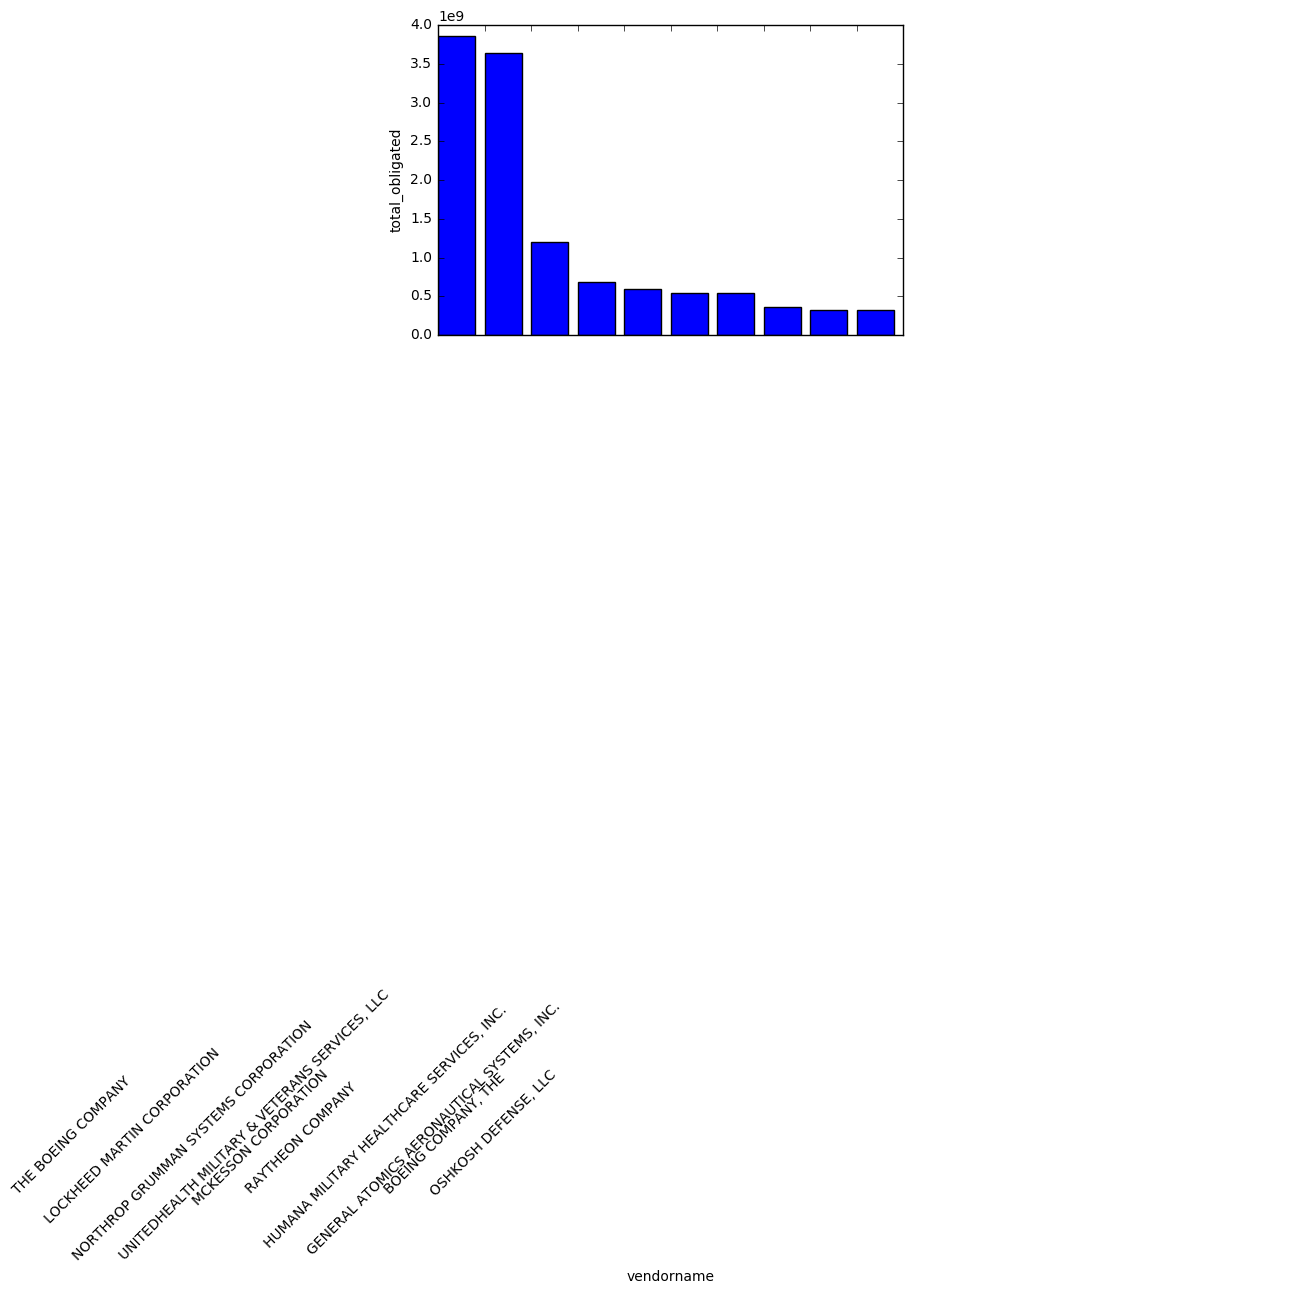

In [58]:
%matplotlib inline
results = _
results.bar()
!echo 'Total value of contracts by Vendor'

Based on our sample, Boeing and Lockheed Martin earned a great deal of money from 2016 Federal Contracts. Each company earns more than 10% of total contracted dollars in FY2016 (~$32b).

** Analyze in Star Schema **
Which non-US countries have the most contract-awarded vendors?

In [59]:
%%sql
SELECT 
    c.vendorcountrycode,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
WHERE c.vendorcountrycode != 'USA: UNITED STATES OF AMERICA'
GROUP BY c.vendorcountrycode
ORDER BY COUNT DESC
LIMIT 20;

20 rows affected.


vendorcountrycode,count
ARE: UNITED ARAB EMIRATES,2472
DEU: GERMANY,1105
JPN: JAPAN,781
CAN: CANADA,551
GBR: UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN,534
DNK: DENMARK,407
"KOR: KOREA, REPUBLIC OF",363
ITA: ITALY,278
CHE: SWITZERLAND,205
MLT: MALTA,182


In [60]:
%%sql
SELECT 
    c.vendorcountrycode,
    SUM(a.dollarsobligated) AS Total_Obligated,
    SUM(a.baseandexercisedoptionsvalue) AS Total_BaseandExercisedOpt,
    SUM(a.baseandalloptionsvalue) AS Total_BaseandAllOpt
FROM gov_contract_fact a
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
WHERE c.vendorcountrycode != 'USA: UNITED STATES OF AMERICA'
GROUP BY c.vendorcountrycode
ORDER BY SUM(a.dollarsobligated) DESC
LIMIT 20;

20 rows affected.


vendorcountrycode,total_obligated,total_baseandexercisedopt,total_baseandallopt
SAU: SAUDI ARABIA,91137200.0,57900000.0,60028000.0
JPN: JAPAN,89786300.0,89905500.0,209006000.0
ARE: UNITED ARAB EMIRATES,78472500.0,80277400.0,80927400.0
CAN: CANADA,54430600.0,53564700.0,70558100.0
"KOR: KOREA, REPUBLIC OF",42458600.0,256689000.0,413913000.0
ESP: SPAIN,38336900.0,38376300.0,38686900.0
DNK: DENMARK,32560000.0,165097000.0,166631000.0
DEU: GERMANY,27705200.0,25553100.0,81762000.0
BHR: BAHRAIN,24218500.0,22226900.0,777025000.0
GBR: UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN,22854000.0,28773900.0,41616000.0


This data shows that vendors based in the United Arab Emirates were awarded the most US federal contracts of non-US based vendors, but vendors in Saudi Arabia earned the most in FY2016.

** Analyze in Star Schema **
Which states have the most contract-awarded vendors?

In [61]:
%%sql
SELECT 
    c.state,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
WHERE c.vendorcountrycode = 'USA: UNITED STATES OF AMERICA'
GROUP BY c.state
ORDER BY COUNT DESC
LIMIT 20;

20 rows affected.


state,count
IL,28647
PA,27656
VA,26557
CA,20344
NJ,16011
TX,11832
NY,9981
FL,8835
MD,7084
NC,5664


We were surprised to find that neither DC, Maryland, or Virginia received the most contracts. However, these states are the location of the vendor's headquarters, so the contract work may still be completed in the DC metropolitan area.

** Analyze in Star Schema **
What are the products/services of the vendors that have been awarded the most contracts?

In [62]:
%%sql
SELECT 
    c.productorservicecode,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
GROUP BY c.productorservicecode
ORDER BY COUNT DESC
LIMIT 20;

20 rows affected.


productorservicecode,count
"6515: MEDICAL AND SURGICAL INSTRUMENTS, EQUIPMENT, AND SUPPLIES",36895
6505: DRUGS AND BIOLOGICALS,21024
"9130: LIQUID PROPELLANTS AND FUELS, PETROLEUM BASE",14511
"5340: HARDWARE, COMMERCIAL",7697
8910: DAIRY FOODS AND EGGS,6390
8940: SPECIAL DIETARY FOODS AND FOOD SPECIALTY PREPARATIONS,6342
"3030: BELTING, DRIVE BELTS, FAN BELTS, AND ACCESSORIES",6073
5680: MISCELLANEOUS CONSTRUCTION MATERIALS,4629
8915: FRUITS AND VEGETABLES,4130
6640: LABORATORY EQUIPMENT AND SUPPLIES,3826


Medical equipment and drugs are the services provided by the most number of FY16 contract awardees.

** Analyze in Star Schema **
What proportion of contracts were awarded to woman-owned vendors?

In [63]:
%%sql
SELECT 
    c.womenownedflag,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
GROUP BY c.womenownedflag
ORDER BY COUNT DESC;

2 rows affected.


womenownedflag,count
False,228618
True,22988


Proportion of contracts awarded to companies owned by women


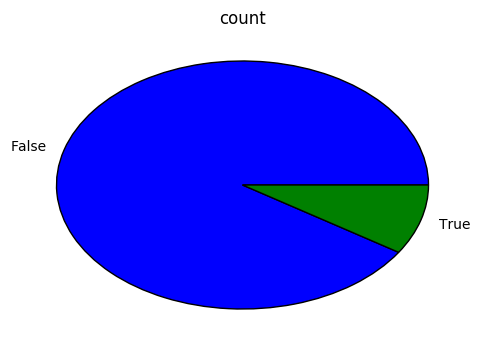

In [64]:
results = _
results.pie()
!echo 'Proportion of contracts awarded to companies owned by women'  

It appears that approximately 10% of the contracts in our sample were awarded to woman-owned vendors.

** Analyze in Star Schema **
What proportion of contracts were awarded to veteran-owned vendors?

In [65]:
%%sql
SELECT 
    c.veteranownedflag,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
GROUP BY c.veteranownedflag
ORDER BY COUNT DESC;

2 rows affected.


veteranownedflag,count
False,234206
True,17400


Proportion of contracts awarded to companies owned by veterans


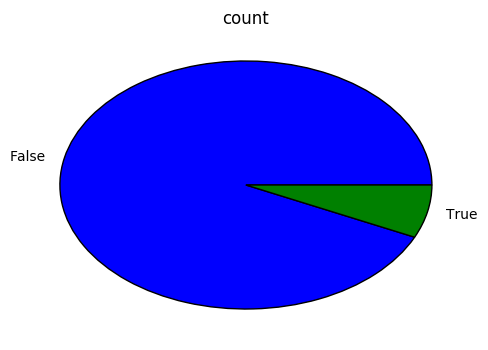

In [66]:
results = _
results.pie()
!echo 'Proportion of contracts awarded to companies owned by veterans'  

Just under 10% of the contracts in our sample were awarded to veteran-owned vendors.

** Analyze in Star Schema **
What proportion of contracts were awarded to minority-owned vendors?

In [67]:
%%sql
SELECT 
    c.minorityownedbusinessflag,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
GROUP BY c.minorityownedbusinessflag
ORDER BY COUNT DESC;

2 rows affected.


minorityownedbusinessflag,count
False,233810
True,17796


Proportion of contracts awarded to companies owned by minorities


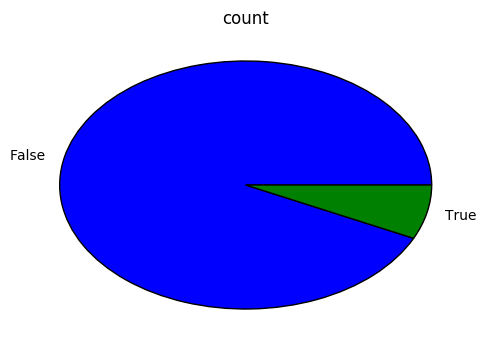

In [68]:
results = _
results.pie()
!echo 'Proportion of contracts awarded to companies owned by minorities'  

Slightly less than 10% of the contracts in our sample were awarded to minority-owned vendors.

** Analyze in Star Schema **
What proportion of contracts were awarded to nonprofit vendors?

In [69]:
%%sql
SELECT 
    c.nonprofitorganizationflag,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
GROUP BY c.nonprofitorganizationflag
ORDER BY COUNT DESC;

2 rows affected.


nonprofitorganizationflag,count
False,245736
True,5870


Proportion of contracts awarded to non-profit companies


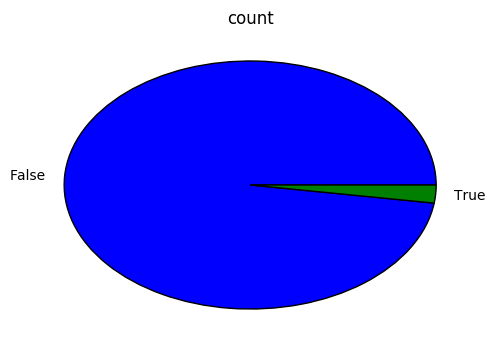

In [70]:
results = _
results.pie()
!echo 'Proportion of contracts awarded to non-profit companies'  

A very small proportion of contracts were awarded to nonprofit vendors. It seems that there may exist a quota for woman-, veteran-, and minority-owned vendors, but no quota exists for nonprofit vendors.

** Analyze in Star Schema **
Which agencies awarded the most contracts?

In [71]:
%%sql
SELECT 
    b.maj_agency_cat,
    COUNT(*)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
GROUP BY b.maj_agency_cat
ORDER BY COUNT DESC
LIMIT 10;

10 rows affected.


maj_agency_cat,count
9700: Department of Defense,194743
3600: Department of Veterans Affairs,13584
4700: General Services Administration,9208
1500: Department of Justice,8128
1900: Department of State,5421
7000: Department of Homeland Security,5217
7500: Department of Health and Human Services,4987
1400: Department of the Interior,4477
1200: Department of Agriculture,4278
8000: National Aeronautics and Space Administration,2452


Number of contracts awarded by Agency


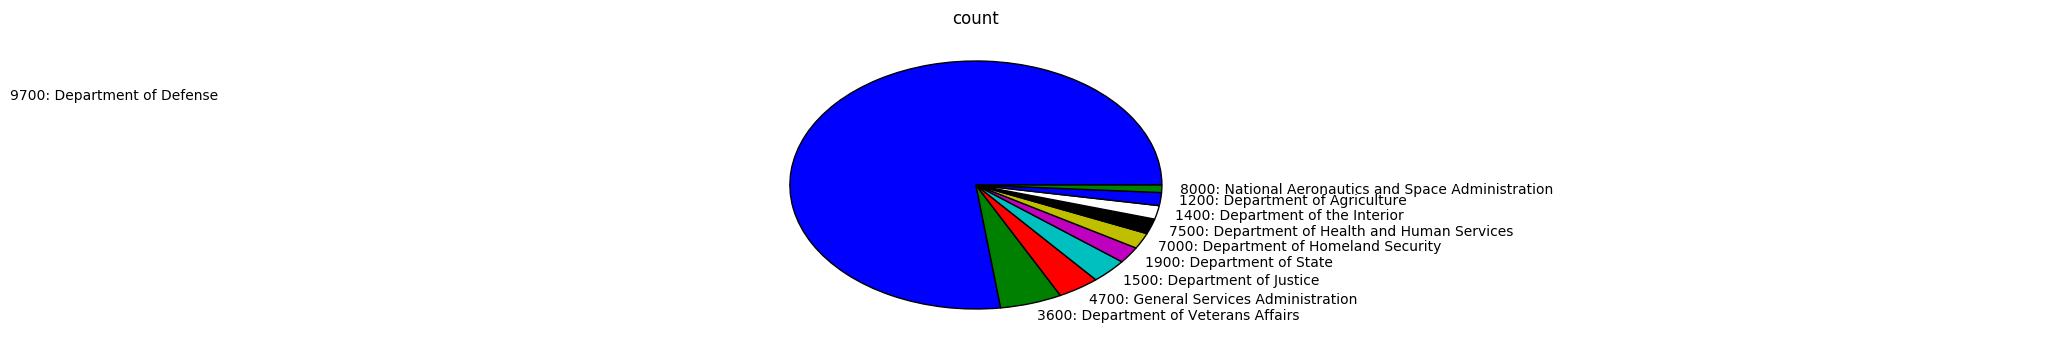

In [72]:
results = _
results.pie()
!echo 'Number of contracts awarded by Agency' 

In [73]:
%%sql
SELECT 
    b.maj_agency_cat,
    SUM(a.dollarsobligated)
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
GROUP BY b.maj_agency_cat
ORDER BY SUM DESC
LIMIT 10;

10 rows affected.


maj_agency_cat,sum
9700: Department of Defense,21197500000.0
8900: Department of Energy,1658380000.0
3600: Department of Veterans Affairs,1471140000.0
7500: Department of Health and Human Services,1466000000.0
8000: National Aeronautics and Space Administration,922817000.0
7000: Department of Homeland Security,802900000.0
1900: Department of State,741400000.0
4700: General Services Administration,508246000.0
1500: Department of Justice,464512000.0
1400: Department of the Interior,373701000.0


Total value of contracts awarded by Agency


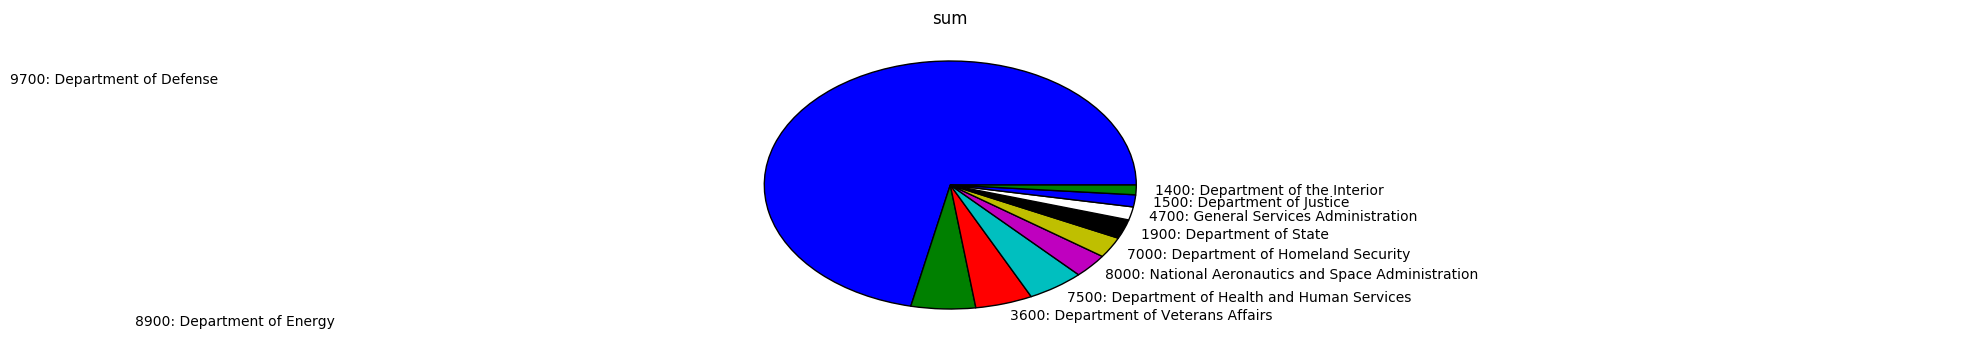

In [74]:
results = _
results.pie()
!echo 'Total value of contracts awarded by Agency' 

We can see from these pie charts that of the top ten agencies letting contracts in FY2016, nearly three-quarters of contracts and about two-thirds of the contract dollars are from agencies in the department of defense.

** Analyze in Star Schema **
What contracting office agencies awarded the most contracts?

In [75]:
%%sql
SELECT 
    b.contractingofficeagencyid,
    COUNT(*),
    SUM(a.dollarsobligated) AS Total_Obligated,
    SUM(a.baseandexercisedoptionsvalue) AS Total_BaseandExercisedOpt,
    SUM(a.baseandalloptionsvalue) AS Total_BaseandAllOpt
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
GROUP BY b.contractingofficeagencyid
ORDER BY COUNT DESC
LIMIT 10;

10 rows affected.


contractingofficeagencyid,count,total_obligated,total_baseandexercisedopt,total_baseandallopt
97AS: DEFENSE LOGISTICS AGENCY,160660,1550410000.0,1551200000.0,6397100000.0
"3600: VETERANS AFFAIRS, DEPARTMENT OF",13584,1471140000.0,1519060000.0,36383800000.0
1700: DEPT OF THE NAVY,12195,4334700000.0,3578760000.0,171965000000.0
2100: DEPT OF THE ARMY,10819,4446930000.0,8141180000.0,-79127300.0
4732: FEDERAL ACQUISITION SERVICE,7465,316606000.0,283259000.0,52234000000.0
5700: DEPT OF THE AIR FORCE,6289,8447300000.0,7798350000.0,27457100000.0
"1900: STATE, DEPARTMENT OF",5355,739183000.0,731996000.0,937031000.0
8000: NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,2452,922817000.0,445183000.0,14594300000.0
7529: NATIONAL INSTITUTES OF HEALTH,2326,456343000.0,266362000.0,21351800000.0
1540: FEDERAL PRISON SYSTEM / BUREAU OF PRISONS,2319,85088600.0,82678200.0,317801000.0


Once again, the Department of Defense reigns supreme in total value of contracts awarded in 2016.

** Analyze in Star Schema **
In what month were most contracts signed?

In [76]:
%%sql
SELECT 
    d.signed_mth,
    COUNT(*)
FROM gov_contract_fact a
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
GROUP BY d.signed_mth
ORDER BY d.signed_mth;

12 rows affected.


signed_mth,count
1,20073
2,22789
3,27037
4,24063
5,23607
6,24803
7,22022
8,20937
9,8128
10,20196


Number of contracts signed by Month


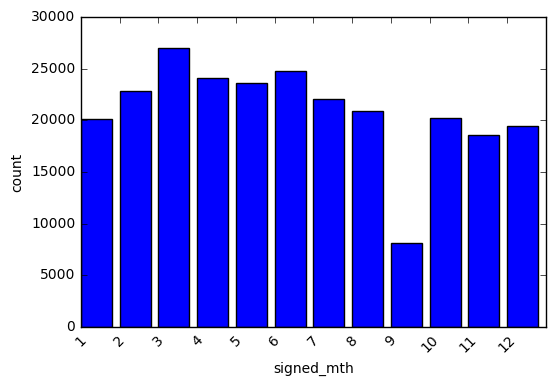

In [77]:
results = _
results.bar()
!echo 'Number of contracts signed by Month' 

In [78]:
%%sql
SELECT 
    d.signed_mth,
    SUM(a.dollarsobligated)
FROM gov_contract_fact a
JOIN contract_date_dimension d ON a.contract_date_key = d.contract_date_key
GROUP BY d.signed_mth
ORDER BY d.signed_mth;

12 rows affected.


signed_mth,sum
1,2171760000.0
2,3658080000.0
3,5767110000.0
4,1749270000.0
5,1488030000.0
6,1836320000.0
7,2136730000.0
8,4711520000.0
9,1623670000.0
10,1836030000.0


Total value of contracts signed by Month


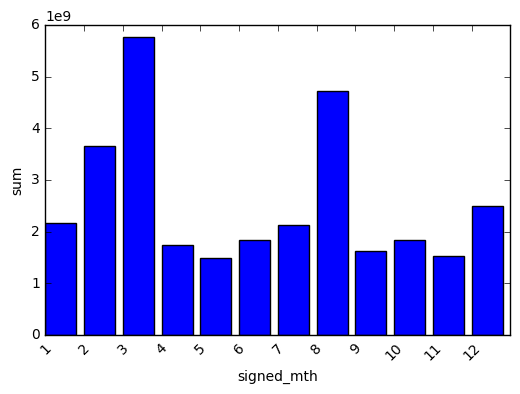

In [79]:
results = _
results.bar()
!echo 'Total value of contracts signed by Month' 

Overall, it appears that an approximately equivalent number of contracts are signed each month, with the exception of September, which is the last month in the government fiscal year. Following our initial explorations we anticipated a much higher number of contracts to be signed in October. The relatively even distribution of contracts being signed throughout the year is surprising. There is, however, a significant increase in the value of contracts signed in  March and in August. We speculate that this is likely due to contracting cycles for defense equipment or services.

** Analyze in Star Schema **
What were the highest dollar-value contracts?

In [80]:
%%sql
SELECT 
    b.maj_agency_cat,
    b.contractingofficeagencyid,
    c.vendorname,
    c.productorservicecode,
    c.principalnaicscode,
    a.dollarsobligated,
    a.baseandexercisedoptionsvalue,
    a.baseandalloptionsvalue,
    c.city,
    c.state,
    c.zipcode
FROM gov_contract_fact a
JOIN gov_agency_dimension b ON a.gov_agency_key = b.gov_agency_key
JOIN vendor_dimension c ON a.vendor_key = c.vendor_key
ORDER BY a.dollarsobligated DESC
LIMIT 10;

10 rows affected.


maj_agency_cat,contractingofficeagencyid,vendorname,productorservicecode,principalnaicscode,dollarsobligated,baseandexercisedoptionsvalue,baseandalloptionsvalue,city,state,zipcode
9700: Department of Defense,5700: DEPT OF THE AIR FORCE,THE BOEING COMPANY,5810: COMMUNICATIONS SECURITY EQUIPMENT AND COMPONENTS,336411: AIRCRAFT MANUFACTURING,2814820000.0,2814820000.0,2814820000.0,SEATTLE,WA,98108
9700: Department of Defense,5700: DEPT OF THE AIR FORCE,LOCKHEED MARTIN CORPORATION,"1510: AIRCRAFT, FIXED WING",336411: AIRCRAFT MANUFACTURING,1899410000.0,1899410000.0,1899410000.0,MARIETTA,GA,30063
9700: Department of Defense,2100: DEPT OF THE ARMY,THE BOEING COMPANY,1680: MISCELLANEOUS AIRCRAFT ACCESSORIES AND COMPONENTS,336411: AIRCRAFT MANUFACTURING,896930000.0,896930000.0,0.0,RIDLEY PARK,PA,19078
9700: Department of Defense,1700: DEPT OF THE NAVY,NORTHROP GRUMMAN SYSTEMS CORPORATION,"1510: AIRCRAFT, FIXED WING",336411: AIRCRAFT MANUFACTURING,803906000.0,50762900.0,0.0,MELBOURNE,FL,32904
9700: Department of Defense,97DH: DEFENSE HEALTH AGENCY (DHA),"HUMANA MILITARY HEALTHCARE SERVICES, INC.",Q201: MEDICAL- GENERAL HEALTH CARE,524114: DIRECT HEALTH AND MEDICAL INSURANCE CARRIERS,522488000.0,191802.0,191802.0,LOUISVILLE,KY,40202
9700: Department of Defense,1700: DEPT OF THE NAVY,LOCKHEED MARTIN CORPORATION,"5841: RADAR EQUIPMENT, AIRBORNE",336411: AIRCRAFT MANUFACTURING,473352000.0,473352000.0,473352000.0,FORT WORTH,TX,76108
9700: Department of Defense,97DH: DEFENSE HEALTH AGENCY (DHA),"UNITEDHEALTH MILITARY & VETERANS SERVICES, LLC",Q201: MEDICAL- GENERAL HEALTH CARE,524114: DIRECT HEALTH AND MEDICAL INSURANCE CARRIERS,402422000.0,0.0,0.0,MINNETONKA,MN,55343
9700: Department of Defense,97DH: DEFENSE HEALTH AGENCY (DHA),"UNITEDHEALTH MILITARY & VETERANS SERVICES, LLC",Q201: MEDICAL- GENERAL HEALTH CARE,524114: DIRECT HEALTH AND MEDICAL INSURANCE CARRIERS,282100000.0,0.0,0.0,MINNETONKA,MN,55343
9700: Department of Defense,5700: DEPT OF THE AIR FORCE,"GENERAL ATOMICS AERONAUTICAL SYSTEMS, INC.","L017: TECHNICAL REPRESENTATIVE- AIRCRAFT LAUNCHING, LANDING, AND GROUND HANDLING EQUIPMENT",336411: AIRCRAFT MANUFACTURING,280143000.0,280143000.0,280143000.0,POWAY,CA,92064
3600: Department of Veterans Affairs,"3600: VETERANS AFFAIRS, DEPARTMENT OF",MCKESSON CORPORATION,6505: DRUGS AND BIOLOGICALS,325412: PHARMACEUTICAL PREPARATION MANUFACTURING,255426000.0,255426000.0,255426000.0,SAN FRANCISCO,CA,94104


The top four highest-value contracts in 2016 (based on our sample) were awarded to companies whose principal NAICS code was Aircraft Manufacturing. Note that the highest value contract in our sample (to Boeing for $2.8b) represents almost 10% of total contracted dollars in FY2016.

## Conclusion

Our sample of data, from the 2016 Federal Contracts data set on usaspending.gov, displays a clear story of federal government contract spending for fiscal year 2016. By far, the highest number of contracts and the highest-value contracts were awarded by the Department of Defense. The contract budget for the Department of Defense may be as much as the contract budget for all other departments combined. The individual contracts awarded in fiscal year 2016 with the highest base value were awarded to companies such as Boeing and Lockheed Martin, whose principal NAICS code is Aircraft Manufacturing. This indicates that the federal government is spending a great deal of contract money on equipment to be used by the Department of Defense.